# 数据读取

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [3]:
family2014 = pd.read_csv('数据/居民出行数据/2014/family_2014.csv',dtype=str)
travel2014 = pd.read_csv('数据/居民出行数据/2014/midtable_2014.csv',dtype=str)
familymember_2014 = pd.read_csv('数据/居民出行数据/2014/family_member_2014.csv',dtype=str)

In [4]:
family2023 = pd.read_csv('数据/居民出行数据/2023/family_total_33169.csv',dtype=str)
travel2023 = pd.read_csv('数据/居民出行数据/2023/midtable_total_33169.csv',dtype=str)
familymember_2023 = pd.read_csv('数据/居民出行数据/2023/familymember_total_33169.csv',dtype=str)

In [5]:
familymember_2023['age'] = 2023 - familymember_2023['出生年份'].astype(int)

In [6]:
familymember_2023.loc[familymember_2023['最高学历'].isna(), '最高学历'] = familymember_2023.loc[familymember_2023['最高学历'].isna(), '教育阶段']


In [7]:
# 改进的特征工程
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plt

class ImprovedFeatureEngineering:
    def __init__(self):
        self.scalers = {}
        self.pcas = {}
        
    def improved_pca_transform(self, data, category_name, explained_variance_ratio=0.95):
        """
        改进的PCA转换，动态选择组件数
        """
        # 先标准化
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        
        # 确定PCA组件数
        pca_temp = PCA()
        pca_temp.fit(data_scaled)
        
        cumsum_ratio = np.cumsum(pca_temp.explained_variance_ratio_)
        n_components = np.argmax(cumsum_ratio >= explained_variance_ratio) + 1
        n_components = min(n_components, data.shape[1], data.shape[0]//10)  # 防止过拟合
        
        # 最终PCA
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(data_scaled)
        
        self.scalers[category_name] = scaler
        self.pcas[category_name] = pca
        
        print(f"{category_name} - 原始维度: {data.shape[1]}, PCA维度: {n_components}, 方差解释: {cumsum_ratio[n_components-1]:.3f}")
        
        return pca_result, n_components
    
    def create_advanced_features(self, familymember_df, family_df):
        """
        创建高级特征
        """
        print("开始改进的特征工程...")
        
        # 1. 教育特征工程
        education_dummies = pd.get_dummies(familymember_df['最高学历'], prefix='edu')
        education_by_family = education_dummies.groupby(familymember_df['家庭编号']).mean()
        
        if len(education_by_family) > 0:
            edu_pca, edu_dims = self.improved_pca_transform(education_by_family, 'education')
            edu_features = pd.DataFrame(edu_pca, 
                                      index=education_by_family.index,
                                      columns=[f'edu_pca_{i}' for i in range(edu_dims)])
        else:
            edu_features = pd.DataFrame()
        
        # 2. 关系特征工程  
        relation_dummies = pd.get_dummies(familymember_df['关系'], prefix='rel')
        relation_by_family = relation_dummies.groupby(familymember_df['家庭编号']).mean()
        
        if len(relation_by_family) > 0:
            rel_pca, rel_dims = self.improved_pca_transform(relation_by_family, 'relation')
            rel_features = pd.DataFrame(rel_pca,
                                      index=relation_by_family.index, 
                                      columns=[f'rel_pca_{i}' for i in range(rel_dims)])
        else:
            rel_features = pd.DataFrame()
        
        # 3. 职业特征工程
        occupation_dummies = pd.get_dummies(familymember_df['职业'], prefix='occ')
        occupation_by_family = occupation_dummies.groupby(familymember_df['家庭编号']).mean()
        
        if len(occupation_by_family) > 0:
            occ_pca, occ_dims = self.improved_pca_transform(occupation_by_family, 'occupation') 
            occ_features = pd.DataFrame(occ_pca,
                                      index=occupation_by_family.index,
                                      columns=[f'occ_pca_{i}' for i in range(occ_dims)])
        else:
            occ_features = pd.DataFrame()
        
        # 4. 人口统计特征
        familymember_df['性别_numeric'] = 2 - familymember_df['性别'].astype(int)
        familymember_df['is_child'] = (familymember_df['age'] < 18).astype(int)
        familymember_df['is_elder'] = (familymember_df['age'] >= 60).astype(int)
        familymember_df['is_working_age'] = ((familymember_df['age'] >= 18) & (familymember_df['age'] < 60)).astype(int)
        familymember_df['license'] = familymember_df['是否有驾照'].fillna('0').astype(int)
        
        # 家庭层面统计特征
        family_stats = familymember_df.groupby('家庭编号').agg({
            'age': ['mean', 'std', 'min', 'max'],
            '性别_numeric': 'mean',  # 性别比例
            'license': 'mean',       # 驾照持有率
            'is_child': ['sum', 'mean'],     # 儿童数量和比例
            'is_elder': ['sum', 'mean'],     # 老人数量和比例  
            'is_working_age': ['sum', 'mean'] # 劳动年龄人口数量和比例
        }).round(4)
        
        # 扁平化列名
        family_stats.columns = ['_'.join(col).strip() for col in family_stats.columns]
        family_stats = family_stats.fillna(0)
        
        # 5. 组合特征
        family_enhanced = family_df.copy()
        
        # 合并所有特征
        all_features = [family_enhanced.set_index('家庭编号')]
        
        if not edu_features.empty:
            all_features.append(edu_features)
        if not rel_features.empty:
            all_features.append(rel_features)  
        if not occ_features.empty:
            all_features.append(occ_features)
        all_features.append(family_stats)
        
        # 外连接合并
        final_features = all_features[0]
        for feature_df in all_features[1:]:
            final_features = final_features.join(feature_df, how='left')
        
        final_features = final_features.fillna(0)
        final_features.reset_index(inplace=True)
        
        # 6. 创建高级组合特征
        numeric_cols = ['家庭成员数量', '家庭工作人口数', '机动车数量', '脚踏自行车数量', 
                       '电动自行车数量', '摩托车数量', '老年代步车数量']

        have_student_family = familymember_df[familymember_df['职业'] == '14'].drop_duplicates(['家庭编号'])[['家庭编号']]
        have_student_family['have_student'] = 1
        final_features = pd.merge(final_features, have_student_family, on='家庭编号', how='left').fillna({'have_student':0})

        from sklearn.preprocessing import LabelEncoder

        # 方法1: 使用LabelEncoder
        le = LabelEncoder()
        final_features['家庭年收入_encoded'] = le.fit_transform(final_features['家庭年收入'])

        for col in numeric_cols:
            if col in final_features.columns:
                final_features[col] = pd.to_numeric(final_features[col], errors='coerce').fillna(0)
        
        # 工作人口比例
        final_features['工作人口比例'] = final_features['家庭工作人口数'] / np.maximum(final_features['家庭成员数量'], 1)
        
        # 人均车辆数
        final_features['人均机动车'] = final_features['机动车数量'] / np.maximum(final_features['家庭成员数量'], 1)
        final_features['人均自行车'] = (final_features['脚踏自行车数量'] + final_features['电动自行车数量']) / np.maximum(final_features['家庭成员数量'], 1)
        
        # 抚养比 = (儿童数 + 老人数) / 劳动年龄人口数
        final_features['抚养比'] = (final_features['is_child_sum'] + final_features['is_elder_sum']) / np.maximum(final_features['is_working_age_sum'], 1)
        
        # 年龄离散程度（变异系数）
        final_features['年龄变异系数'] = final_features['age_std'] / np.maximum(final_features['age_mean'], 1)
        final_features['年龄变异系数'] = final_features['年龄变异系数'].fillna(0)
        
        # 家庭发展阶段
        def family_stage(row):
            if row['is_child_sum'] > 0 and row['age_mean'] < 40:
                return 0  # 年轻有孩家庭
            elif row['is_child_sum'] > 0 and row['age_mean'] >= 40:  
                return 1  # 成熟有孩家庭
            elif row['is_elder_sum'] > 0:
                return 2  # 老年家庭
            elif row['家庭成员数量'] == 1:
                return 3  # 单身家庭
            else:
                return 4  # 其他成人家庭
                
        final_features['家庭发展阶段'] = final_features.apply(family_stage, axis=1)

        # 家庭规模分类
        def classify_family_size(size):
            if size == 1:
                return 0  # 单人家庭
            elif size == 2:
                return 1  # 小家庭
            elif size <= 4:
                return 2  # 中等家庭
            else:
                return 3  # 大家庭
        
        final_features['家庭规模类型'] = final_features['家庭成员数量'].astype(int).apply(classify_family_size)
        # 年龄分组
        def classify_family_age(age):
            if age < 35:
                return 0  # 年轻家庭
            elif age < 50:
                return 1  # 中年家庭
            elif age < 65:
                return 2  # 成熟家庭
            else:
                return 3  # 老年家庭
        
        final_features['家庭年龄组'] = final_features['age_mean'].apply(classify_family_age)
        
        print(f"特征工程完成，最终特征数: {final_features.shape[1]}")
        return final_features


In [8]:
# 创建改进的特征工程实例
feature_engineer = ImprovedFeatureEngineering()

# 应用改进的特征工程
improved_features = feature_engineer.create_advanced_features(familymember_2023, family2023)

开始改进的特征工程...
education - 原始维度: 9, PCA维度: 8, 方差解释: 1.000
relation - 原始维度: 16, PCA维度: 14, 方差解释: 0.956
occupation - 原始维度: 20, PCA维度: 18, 方差解释: 0.954
特征工程完成，最终特征数: 125


In [6]:
from sklearn.decomposition import PCA

# 每个家庭的职业分布
occupation_dummies = pd.get_dummies(familymember_2023['最高学历'])
occupation_by_family = occupation_dummies.groupby(familymember_2023['家庭编号']).mean()

# PCA降维
pca = PCA(n_components=4)
occupation_pca = pca.fit_transform(occupation_by_family)
occupation_embed = pd.DataFrame(occupation_pca, columns=['edu1','edu2','edu3', 'edu4'])

print(f"原始维度: {occupation_by_family.shape}")        # (150, 4)
print(f"降维后: {occupation_embed.shape}")      # (150, 3)

# 查看方差解释比例
print(f"方差解释比例: {pca.explained_variance_ratio_}")
print(f"累计方差比例: {pca.explained_variance_ratio_.sum():.4f}")

原始维度: (33169, 9)
降维后: (33169, 4)
方差解释比例: [0.31801663 0.24465234 0.19364779 0.1110718 ]
累计方差比例: 0.8674


In [7]:
familymember_2023 = pd.concat([familymember_2023, occupation_embed], axis=1)

In [8]:
from sklearn.decomposition import PCA

# 每个家庭的职业分布
occupation_dummies = pd.get_dummies(familymember_2023['关系'])
occupation_by_family = occupation_dummies.groupby(familymember_2023['家庭编号']).mean()

# PCA降维
pca = PCA(n_components=4)
occupation_pca = pca.fit_transform(occupation_by_family)
occupation_embed = pd.DataFrame(occupation_pca, columns=['relation1','relation2','relation3', 'relation4'])

print(f"原始维度: {occupation_by_family.shape}")        # (150, 4)
print(f"降维后: {occupation_embed.shape}")      # (150, 3)

# 查看方差解释比例
print(f"方差解释比例: {pca.explained_variance_ratio_}")
print(f"累计方差比例: {pca.explained_variance_ratio_.sum():.4f}")

原始维度: (33169, 16)
降维后: (33169, 4)
方差解释比例: [0.38335196 0.27258566 0.15114017 0.10588226]
累计方差比例: 0.9130


In [9]:
familymember_2023 = pd.concat([familymember_2023, occupation_embed], axis=1)

In [10]:
from sklearn.decomposition import PCA

# 每个家庭的职业分布
occupation_dummies = pd.get_dummies(familymember_2023['职业'])
occupation_by_family = occupation_dummies.groupby(familymember_2023['家庭编号']).mean()

# PCA降维
pca = PCA(n_components=8)
occupation_pca = pca.fit_transform(occupation_by_family)
occupation_embed = pd.DataFrame(occupation_pca, columns=['occ1','occ2','occ3', 'occ4', 'occ5', 'occ6', 'occ7', 'occ8'])

print(f"原始维度: {occupation_by_family.shape}")        # (150, 4)
print(f"降维后: {occupation_embed.shape}")      # (150, 3)

# 查看方差解释比例
print(f"方差解释比例: {pca.explained_variance_ratio_}")
print(f"累计方差比例: {pca.explained_variance_ratio_.sum():.4f}")

原始维度: (33169, 20)
降维后: (33169, 8)
方差解释比例: [0.27411929 0.18280705 0.11454729 0.07449952 0.06830698 0.06411538
 0.05284812 0.04338829]
累计方差比例: 0.8746


In [14]:
familymember_2023 = pd.concat([familymember_2023, occupation_embed], axis=1)

In [ ]:
familymember_2023['性别'] = 2 - familymember_2023['性别'].astype(int)


In [15]:
familymember_2023['is_child'] = (familymember_2023['age'] < 18).astype(int)
familymember_2023['is_elder'] = (familymember_2023['age'] >= 60).astype(int)

In [19]:
familymember_2023['license'] = familymember_2023['是否有驾照'].fillna('0').astype(int)

In [25]:
familymember_feature = familymember_2023.groupby(['家庭编号'])[['license', 'edu1', 'edu2', 'edu3', 'edu4',
       'relation1', 'relation2', 'relation3', 'relation4', 'occ1', 'occ2',
       'occ3', 'occ4', 'occ5', 'occ6', 'occ7', 'occ8', 'is_child', 'is_elder']].mean()

In [32]:
familymember_feature = pd.concat([familymember_2023.groupby(['家庭编号'])['age'].agg(['mean', 'std']).rename(columns={'mean':'age_mean','std':'age_std'}), familymember_feature], axis=1)

In [33]:
familymember_feature['age_std'] = familymember_feature['age_std'].fillna(-1)

## 家庭变量筛选

In [34]:
family2023[['家庭成员数量']].value_counts()

家庭成员数量
2         16027
3          9865
1          4120
4          2390
5           699
6            66
7             2
Name: count, dtype: int64

In [35]:
family2023['摩托车数量'].value_counts()

摩托车数量
0    32413
1      734
2       20
4        1
3        1
Name: count, dtype: int64

In [36]:
family2023 = pd.merge(family2023, familymember_feature, on='家庭编号', how='left')

In [39]:
## 家庭连续型变量
family2023[['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','age_mean','age_std','license', 'edu1',
       'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3',
       'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7',
       'occ8', 'is_child', 'is_elder']]

,家庭成员数量,家庭工作人口数,机动车数量,脚踏自行车数量,电动自行车数量,摩托车数量,老年代步车数量,age_mean,age_std,license,edu1,edu2,edu3,edu4,relation1,relation2,relation3,relation4,occ1,occ2,occ3,occ4,occ5,occ6,occ7,occ8,is_child,is_elder
0,3,2,1,3,0,0,0,45.000000,16.462078,1.000000,0.108451,-0.270194,-0.161213,-0.090821,0.102905,0.261758,-0.044276,-0.068151,0.208283,0.066013,-0.036392,-0.028388,-0.002287,0.015874,0.137286,0.140146,0.000000,0.000000
1,2,2,1,1,0,0,0,46.500000,0.707107,0.500000,0.348711,-0.143957,-0.039081,-0.119307,0.147218,-0.063061,-0.112808,-0.025665,-0.273637,-0.029683,-0.190046,-0.048484,-0.286233,-0.190029,-0.091240,-0.000261,0.000000,0.000000
2,2,2,1,0,1,0,0,33.500000,0.707107,1.000000,0.287081,0.176910,0.095628,-0.110003,0.172711,0.208186,0.020930,0.072692,-0.257832,0.278788,0.253873,0.035187,-0.015803,-0.008127,-0.048714,-0.008424,0.000000,0.000000
3,3,2,1,1,1,0,0,37.333333,17.785762,0.666667,0.077309,0.080705,0.075461,-0.128103,0.155979,-0.008131,-0.150669,-0.035233,0.185081,-0.040863,0.039069,0.231446,-0.033997,-0.014238,-0.077493,-0.010951,0.333333,0.000000
4,2,2,1,1,2,0,0,34.000000,0.000000,1.000000,0.552116,0.070133,-0.013306,0.175959,-0.014315,0.042407,-0.173072,-0.053925,0.073012,-0.128663,-0.135230,-0.157212,-0.167182,-0.093370,0.125072,-0.016757,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33164,1,0,0,1,0,0,0,66.000000,-1.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
33165,3,1,0,2,1,0,0,50.333333,15.947832,0.333333,-0.329110,-0.097291,-0.200947,-0.105015,0.170386,0.096148,-0.069676,-0.063668,-0.186787,-0.274522,-0.315380,0.250793,0.016673,0.146154,-0.102565,0.001167,0.000000,0.333333
33166,3,2,1,1,1,0,0,33.333333,16.772994,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.333333,0.000000
33167,3,2,1,1,1,0,0,41.333333,15.373137,0.666667,0.018966,0.149973,-0.129527,0.058063,-0.111966,-0.197085,-0.003850,-0.015504,-0.425940,0.340500,-0.076193,0.285092,-0.055343,-0.015652,-0.092592,-0.019575,0.000000,0.000000


In [40]:
have_student_family = familymember_2023[familymember_2023['职业'] == '14'].drop_duplicates(['家庭编号'])[['家庭编号']]
have_student_family['have_student'] = 1

In [41]:
family2023 = pd.merge(family2023, have_student_family, on='家庭编号', how='left').fillna({'have_student':0})

In [42]:
## 家庭离散型变量
family2023[['have_student','家庭年收入']]

,have_student,家庭年收入
0,0.0,E
1,0.0,C
2,0.0,D
3,1.0,G
4,0.0,B
...,...,...
33164,0.0,B
33165,0.0,C
33166,1.0,D
33167,0.0,E


In [43]:
from sklearn.preprocessing import LabelEncoder

# 方法1: 使用LabelEncoder
le = LabelEncoder()
family2023['家庭年收入_encoded'] = le.fit_transform(family2023['家庭年收入'])

# 查看编码映射关系
mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("编码映射关系:", mapping)

编码映射关系: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'I': 7, 'J': 8, 'K': 9}


In [44]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# 假设 activite_duration_2014 已经加载为 DataFrame
# 选择 activity1 到 activity8 作为输入特征
features = family2023[['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','家庭年收入_encoded','age_mean','age_std','license', 'edu1',
       'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3',
       'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7',
       'occ8', 'is_child', 'is_elder']].astype(float)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default 

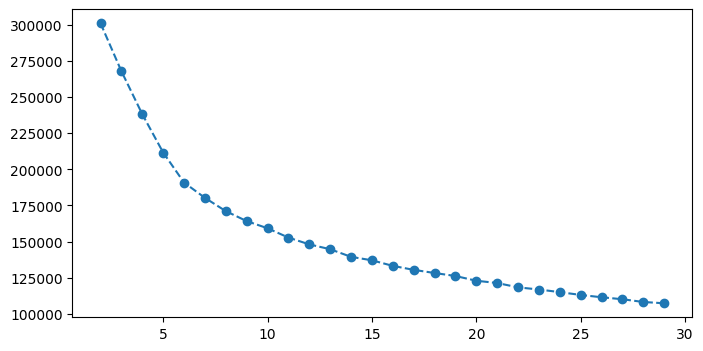

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt

# 假设 activite_duration_2014 已经加载为 DataFrame
# 选择 activity1 到 activity8 作为输入特征
features = family2023[['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','家庭年收入_encoded','age_mean','age_std','license', 'edu1',
       'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3',
       'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7',
       'occ8', 'is_child', 'is_elder']].astype(int)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

inertia = []
for k in range(2, 30):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)

    inertia.append(kmeans.inertia_)

# 绘制手肘法图表
plt.figure(figsize=(8, 4))
plt.plot(range(2, 30), inertia, marker='o', linestyle='--')

# 将聚类结果添加到原 DataFrame 中
# activite_duration_2014['cluster'] = kmeans.labels_
plt.show()

In [22]:
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(X_scaled)


features['cluster'] = kmeans.labels_

/home/cranehh/anaconda3/envs/DiT/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [23]:
features['cluster'].value_counts() / len(features)

cluster
2    0.168410
9    0.151437
0    0.139407
4    0.112907
5    0.098164
1    0.092014
7    0.087552
6    0.081220
8    0.046097
3    0.022792
Name: count, dtype: float64

In [24]:
features = pd.concat([family2023[['家庭编号']],features], axis = 1)

In [25]:
features

,家庭编号,家庭成员数量,家庭工作人口数,机动车数量,脚踏自行车数量,电动自行车数量,摩托车数量,老年代步车数量,家庭平均年龄,家庭年龄标准差,家庭年收入_encoded,have_student,cluster
0,010703000170,3,2,1,3,0,0,0,45,16,4,0,8
1,040603000173,2,2,1,1,0,0,0,46,0,2,0,9
2,010305000086,2,2,1,0,1,0,0,33,0,3,0,9
3,040505000015,3,2,1,1,1,0,0,37,17,6,1,2
4,120201000011,2,2,1,1,2,0,0,34,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33164,132021000002,1,0,0,1,0,0,0,66,-1,1,0,4
33165,070901000019,3,1,0,2,1,0,0,50,15,2,0,8
33166,100702000017,3,2,1,1,1,0,0,33,16,3,1,2
33167,132401000024,3,2,1,1,1,0,0,41,15,4,0,6


In [28]:
family2023['家庭无业人口数'].value_counts()

家庭无业人口数
0    28707
1     3685
2      742
3       34
4        1
Name: count, dtype: int64

In [27]:
family2023

,编号,家庭编号,所属城区,所属街道,所属社区,添加地址,家庭具体地址,小区编号,小区编号的环路代码,家庭流动人口数,家庭工作人口数,家庭学生人口数,家庭无业人口数,地址经度,地址纬度,调查员编号,调查员姓名,第1次入户时间,第1次敲门状态,第2次入户时间,第2次敲门状态,出行日期,家庭成员数量,住房类型,住房类型其他,住房类型_final,建筑面积,在北京是否更换过居住地址,本户居住起始年份,上一居住地址,上一居住地址经度,上一居住地址纬度,上一居住小区编码,家庭年收入,取快递次数,取外卖次数,脚踏自行车数量,电动自行车数量,摩托车数量,老年代步车数量,机动车数量,状态,成员信息登记状态,成员信息创建时间,成员信息更新时间,车辆信息登记状态,车辆信息创建时间,车辆信息更新时间,住房信息登记状态,住房信息创建时间,住房信息更新时间,出行信息登记状态,行程信息创建时间,出行信息更新时间,调查时的所在位置经度,调查时的所在位置纬度,调查时的所在位置定位时间,创建时间,修改时间,年度,项目名称,type,no.na,家庭平均年龄,家庭年龄标准差,have_student,家庭年收入_encoded
0,000b2a2b-1333-4d28-8056-8ab1a30870ad,010703000170,2,月坛街道,月坛社区,月坛西街东里21号院16,月坛西街东里21号院1号楼905,010703,3,0,2,0,0,116.349759,39.916528,e4decdee-2b98-4231-b1be-80537da8f151,郭建立,2023/5/15 0:00:00,success,2023/5/18 0:00:00,success,2023/5/16 0:00:00,3,1,-1,1,43.5,0,-1,-1,0,0,-1,E,0,0,3,0,0,0,1,success,saved,2023/5/27 13:25:45,2023/5/27 13:25:44,saved,2023/5/10 10:30:07,2023/6/5 8:49:48,saved,-1,2023/5/27 13:28:51,saved,-1,2023/6/5 8:50:03,NaN,NaN,NaN,2023/5/10 10:30:07,2023/6/8 10:48:55,2023,第六次北京城市交通综合调查（交研都市）,jy,3,45.000000,16.462078,0.0,4
1,003d14b7-e5fb-4b53-b10d-ebb4342af81b,040603000173,2,广安门外街道,鸭子桥社区,运达小区004,运达小区18-6-201,040501,3,0,2,0,0,116.345741,39.877241,2b4ad7c1-b331-484b-b6f3-3ba60e5c012e,孙丽群,2023/5/20 0:00:00,success,2023/5/22 0:00:00,success,2023/5/21 0:00:00,2,1,-1,1,70,0,-1,-1,0,0,-1,C,2,0,1,0,0,0,1,success,saved,2023/5/22 12:35:02,2023/5/22 12:36:29,saved,2023/5/20 8:56:11,2023/5/22 12:37:32,saved,-1,2023/5/22 12:37:51,saved,-1,2023/5/22 12:42:31,116.345699,39.877231,2023/5/22 15:12:50,2023/5/20 8:56:11,2023/6/4 22:13:44,2023,第六次北京城市交通综合调查（交研都市）,jy,0,46.500000,0.707107,0.0,2
2,00469d0e-2b5f-476f-bf86-ee554e9e3752,010305000086,2,展览路街道,新华里社区,新华里16号院10号楼020,新华里16号院10-2-702,010512,3,0,2,0,0,116.352423,39.935196,0d9d0be5-91d5-42b4-97ed-696f02298e48,王莹,2023/5/23 0:00:00,success,2023/5/25 0:00:00,success,2023/5/24 0:00:00,2,1,-1,1,127,0,-1,-1,0,0,-1,D,2,0,0,1,0,0,1,passed,saved,2023/5/25 9:53:24,2023/5/25 9:53:23,saved,2023/5/22 15:25:46,2023/5/25 9:55:30,saved,-1,2023/5/25 9:55:49,saved,-1,2023/5/25 10:02:23,116.352662,39.935372,2023/5/25 9:18:36,2023/5/22 15:25:46,2023/6/13 11:27:27,2023,第六次北京城市交通综合调查（交研都市）,jy,0,33.500000,0.707107,0.0,3
3,004aadb2-8693-438e-b358-56e75ade505e,040505000015,2,广安门外街道,红莲南里社区居委会,常青藤嘉园15,西城区常青藤嘉园2号院3-1106,040506,3,0,2,1,0,116.333144,39.880115,851e42f9-61cd-4ca8-9f28-5ae0544d4b97,李满慧,2023/4/19 0:00:00,success,2023/4/21 0:00:00,success,2023/4/20 0:00:00,3,1,-1,1,70,0,-1,-1,0,0,-1,G,1,0,1,1,0,0,1,success,saved,2023/4/23 18:23:57,2023/4/23 18:23:57,saved,2023/4/17 15:15:24,2023/4/24 22:30:47,saved,-1,2023/4/23 18:24:57,saved,-1,2023/4/25 15:50:29,NaN,NaN,NaN,2023/4/17 15:15:24,2023/5/9 10:37:51,2023,第六次北京城市交通综合调查（交研都市）,jy,3,37.333333,17.785762,1.0,6
4,004c99c2-2690-461d-8463-d1850d911656,120201000011,11,庞各庄镇,东中堡村村委会,东中堡村19,东中堡村东街北三条4号,120203,7,0,2,0,0,116.324315,39.644375,d9554d3c-a98a-4f36-afa7-f9565c2d1d76,崔玉晶,2023/6/6 0:00:00,success,2023/6/8 0:00:00,success,2023/6/7 0:00:00,2,6,-1,6,200,0,-1,-1,0,0,-1,B,0,0,1,2,0,0,1,success,saved,2023/6/6 11:30:46,2023/6/6 11:30:46,saved,2023/6/4 23:14:28,2023/6/6 11:32:13,saved,-1,2023/6/6 11:32:35,saved,-1,2023/6/29 11:25:59,116.324315,39.644375,2023/6/6 11:28:16,2023/6/4 23:14:28,2023/6/29 11:26:10,2023,第六次北京城市交通综合调查（交研都市）,jy,0,34.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33164,fff6ec7b-8fa8-453c-b557-2f4c3f6eb05b,132021000002,7,长阳镇,加州水郡东区社区,01,64号楼1单元802,132021,6,0,0,0,0,116.167937,39.767044,6464bd57-78b5-c674-0013-007c01cd8e3e,左金风,2023/5/19 0:00:00,success,2023/5/23 0:00:00,success,2023/5/22 0:00:00,1,1,-1,1,110,0,-1,-1,0,0,-1,B,0,0,1,0,0,0,0,success,saved,2023/5/20 20:13:46,2023/5/23 15:18:21,saved,2023/5/19 10:21:45,2023/5/23 15:18:34,saved,-1,2023/5/23 15:18:50,saved,-1,2023/5/23 20:11:10,116.168532,39.767891,2

In [ ]:
features.groupby('cluster').mean().sort_values(by='家庭平均年龄', ascending=False)

## 0: 小家庭,低收入，无学生

,家庭编号,家庭成员数量,家庭工作人口数,机动车数量,脚踏自行车数量,电动自行车数量,摩托车数量,老年代步车数量,家庭平均年龄,家庭年龄标准差,家庭年收入_encoded,have_student
cluster,,,,,,,,,,,,
4,inf,1.793591,0.138585,0.134579,0.519359,0.449132,0.000000,0.000534,64.068091,1.053672,1.073698,0.000000
7,inf,2.440771,0.971074,0.392562,0.509986,0.732782,0.000000,1.011708,53.409780,12.199380,1.905992,0.053719
0,inf,2.479455,1.017085,0.448962,0.527033,0.705234,0.000000,0.000000,51.987889,17.779196,2.042604,0.010164
8,inf,3.056900,1.551995,0.645520,2.183126,1.360366,0.000000,0.107914,48.858077,15.115108,3.547417,0.193591
6,inf,3.325538,2.262806,0.885672,0.388270,0.923534,0.000000,0.019673,44.318857,15.649963,3.266518,0.000000
5,inf,2.121007,1.937346,0.086609,0.390971,1.516278,0.000000,0.000614,40.833845,3.595516,2.400184,0.000000
9,inf,1.798328,1.661557,1.027872,0.271551,0.634481,0.000000,0.000398,39.830978,0.954609,2.519013,0.000000
3,inf,2.486772,1.686508,0.511905,0.441799,0.640212,1.033069,0.103175,39.793651,9.141534,2.589947,0.198413
1,inf,1.334535,1.178571,0.001311,0.274902,0.562910,0.000000,0.000328,38.750983,-0.166776,1.661533,0.007536


In [ ]:
familymember_2023 = pd.merge(familymember_2023, features[['家庭编号','cluster']], on='家庭编号', how='left')

In [40]:
features.to_csv('数据/family_cluster.csv', index=False)

# 密度聚类

In [57]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import hdbscan
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

class FamilyClusteringWithHDBSCAN:
    def __init__(self, min_cluster_size=500, min_samples=20, metric='euclidean'):
        """
        初始化HDBSCAN聚类器
        
        Parameters:
        -----------
        min_cluster_size : int, default=100
            最小聚类大小，控制聚类的粗细程度
        min_samples : int, default=20
            核心样本的最小邻居数
        metric : str, default='euclidean'
            距离度量方式
        """
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
        self.metric = metric
        self.clusterer = None
        self.scaler = StandardScaler()
        self.cluster_labels_ = None
        self.noise_count_ = 0
        
    def feature_engineering(self, family_df):
        """
        特征工程：基于现有数据创建新特征
        
        Parameters:
        -----------
        family_df : DataFrame
            原始家庭数据
            
        Returns:
        --------
        DataFrame : 处理后的特征数据
        """
        features_df = family_df.copy()
        
        # 创建组合特征
        
        # 工作人口比例
        features_df['工作人口比例'] = features_df['家庭工作人口数'].astype(int) / np.maximum(features_df['家庭成员数量'].astype(int), 1)
        
        # 家庭规模分类
        def classify_family_size(size):
            if size == 1:
                return 0  # 单人家庭
            elif size == 2:
                return 1  # 小家庭
            elif size <= 4:
                return 2  # 中等家庭
            else:
                return 3  # 大家庭
        
        features_df['家庭规模类型'] = features_df['家庭成员数量'].astype(int).apply(classify_family_size)
        # 年龄分组
        def classify_family_age(age):
            if age < 35:
                return 0  # 年轻家庭
            elif age < 50:
                return 1  # 中年家庭
            elif age < 65:
                return 2  # 成熟家庭
            else:
                return 3  # 老年家庭
        
        features_df['家庭年龄组'] = features_df['age_mean'].apply(classify_family_age)
        
        return features_df
    
    def prepare_features(self, features_df):
        """
        准备用于聚类的特征矩阵
        
        Parameters:
        -----------
        features_df : DataFrame
            特征工程后的数据
            
        Returns:
        --------
        ndarray : 标准化后的特征矩阵
        list : 特征列名
        """
        # 选择数值型特征进行聚类
        feature_columns = ['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','家庭年收入_encoded','have_student', '工作人口比例', '家庭规模类型', '家庭年龄组','age_mean','age_std','license', 'edu1',
       'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3',
       'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7',
       'occ8', 'is_child', 'is_elder']
        
        # 确保所有特征列都存在
        available_features = [col for col in feature_columns if col in features_df.columns]
        print(f"使用特征: {available_features}")
        
        # 提取特征矩阵
        X = features_df[available_features].astype(float)
        
        # 处理缺失值
        X = X.fillna(X.median())
        
        # 标准化
        X_scaled = self.scaler.fit_transform(X)
        
        return X_scaled, available_features
    
    def fit_hdbscan(self, X_scaled):
        """
        执行HDBSCAN聚类
        
        Parameters:
        -----------
        X_scaled : ndarray
            标准化后的特征矩阵
            
        Returns:
        --------
        ndarray : 聚类标签（包含噪点标签-1）
        """
        print("开始HDBSCAN聚类...")
        print(f"参数设置: min_cluster_size={self.min_cluster_size}, min_samples={self.min_samples}")
        
        # 创建HDBSCAN聚类器
        self.clusterer = hdbscan.HDBSCAN(
            min_cluster_size=self.min_cluster_size,
            min_samples=self.min_samples,
            metric=self.metric,
            cluster_selection_method='eom',  # 使用EOM方法选择聚类
            allow_single_cluster=False
        )
        
        # 执行聚类
        cluster_labels = self.clusterer.fit_predict(X_scaled)
        
        # 统计聚类结果
        unique_labels = np.unique(cluster_labels)
        n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
        n_noise = list(cluster_labels).count(-1)
        
        print(f"聚类完成:")
        print(f"  - 发现聚类数量: {n_clusters}")
        print(f"  - 噪声点数量: {n_noise} ({n_noise/len(cluster_labels)*100:.2f}%)")
        
        self.noise_count_ = n_noise
        return cluster_labels
    
    def assign_noise_points(self, X_scaled, cluster_labels, k_neighbors=5):
        """
        使用最近邻方法为噪点分配聚类标签
        
        Parameters:
        -----------
        X_scaled : ndarray
            标准化后的特征矩阵
        cluster_labels : ndarray
            包含噪点的聚类标签
        k_neighbors : int, default=5
            考虑的最近邻数量
            
        Returns:
        --------
        ndarray : 处理噪点后的聚类标签
        """
        if self.noise_count_ == 0:
            print("无噪点需要处理")
            return cluster_labels
        
        print(f"开始处理 {self.noise_count_} 个噪点...")
        
        # 复制标签数组
        final_labels = cluster_labels.copy()
        
        # 识别噪点和非噪点
        noise_mask = cluster_labels == -1
        clean_mask = ~noise_mask
        
        if clean_mask.sum() == 0:
            raise ValueError("所有点都是噪点，无法进行最近邻分配！")
        
        # 构建最近邻模型（仅使用非噪点）
        nn = NearestNeighbors(n_neighbors=min(k_neighbors, clean_mask.sum()))
        nn.fit(X_scaled[clean_mask])
        
        # 为每个噪点找到最近邻
        noise_points = X_scaled[noise_mask]
        distances, indices = nn.kneighbors(noise_points)
        
        # 获取非噪点的标签
        clean_labels = cluster_labels[clean_mask]
        
        # 为每个噪点分配标签
        assigned_count = 0
        for i, noise_idx in enumerate(np.where(noise_mask)[0]):
            # 获取最近邻的标签
            neighbor_labels = clean_labels[indices[i]]
            
            # 使用加权投票（距离越近权重越大）
            weights = 1 / (distances[i] + 1e-8)  # 避免除零
            
            # 计算加权投票
            unique_labels = np.unique(neighbor_labels)
            weighted_votes = {}
            
            for label in unique_labels:
                mask = neighbor_labels == label
                weighted_votes[label] = weights[mask].sum()
            
            # 选择权重最大的标签
            best_label = max(weighted_votes.keys(), key=weighted_votes.get)
            final_labels[noise_idx] = best_label
            assigned_count += 1
        
        print(f"噪点处理完成，成功分配 {assigned_count} 个噪点")
        
        return final_labels
    
    def evaluate_clustering(self, X_scaled, cluster_labels):
        """
        评估聚类质量
        
        Parameters:
        -----------
        X_scaled : ndarray
            标准化后的特征矩阵
        cluster_labels : ndarray
            聚类标签
            
        Returns:
        --------
        dict : 评估指标
        """
        # 排除噪点计算评估指标
        valid_mask = cluster_labels >= 0
        if valid_mask.sum() < 2:
            return {"error": "有效聚类点太少，无法评估"}
        
        X_valid = X_scaled[valid_mask]
        labels_valid = cluster_labels[valid_mask]
        
        # 如果只有一个聚类，无法计算轮廓系数
        if len(np.unique(labels_valid)) < 2:
            return {"error": "聚类数量太少，无法评估"}
        
        try:
            silhouette = silhouette_score(X_valid, labels_valid)
            calinski_harabasz = calinski_harabasz_score(X_valid, labels_valid)
            
            # 聚类分布统计
            cluster_counts = Counter(cluster_labels[cluster_labels >= 0])
            
            metrics = {
                "silhouette_score": silhouette,
                "calinski_harabasz_score": calinski_harabasz,
                "n_clusters": len(cluster_counts),
                "cluster_distribution": dict(cluster_counts),
                "min_cluster_size": min(cluster_counts.values()) if cluster_counts else 0,
                "max_cluster_size": max(cluster_counts.values()) if cluster_counts else 0,
                "noise_ratio": self.noise_count_ / len(cluster_labels)
            }
            
            return metrics
            
        except Exception as e:
            return {"error": f"评估失败: {str(e)}"}
    
    def fit_predict(self, family_df):
        """
        完整的聚类流程
        
        Parameters:
        -----------
        family_df : DataFrame
            原始家庭数据
            
        Returns:
        --------
        ndarray : 最终聚类标签
        dict : 聚类评估结果
        """
        print("=== 开始家庭聚类分析 ===")
        
        # 1. 特征工程
        print("\n1. 特征工程...")
        features_df = self.feature_engineering(family_df)
        
        # 2. 准备特征矩阵
        print("\n2. 准备特征矩阵...")
        X_scaled, feature_names = self.prepare_features(features_df)
        print(f"特征矩阵形状: {X_scaled.shape}")
        
        # 3. HDBSCAN聚类
        print("\n3. 执行HDBSCAN聚类...")
        cluster_labels = self.fit_hdbscan(X_scaled)
        
        # 4. 处理噪点
        print("\n4. 处理噪点...")
        final_labels = self.assign_noise_points(X_scaled, cluster_labels)
        
        # 5. 评估聚类质量
        print("\n5. 评估聚类质量...")
        evaluation = self.evaluate_clustering(X_scaled, final_labels)
        
        # 保存结果
        self.cluster_labels_ = final_labels
        self.features_df_ = features_df
        self.X_scaled_ = X_scaled
        self.feature_names_ = feature_names
        
        print("\n=== 聚类分析完成 ===")
        return final_labels, evaluation
    
    def plot_cluster_analysis(self, figsize=(15, 10)):
        """
        可视化聚类结果
        
        Parameters:
        -----------
        figsize : tuple, default=(15, 10)
            图片大小
        """
        if self.cluster_labels_ is None:
            raise ValueError("请先执行聚类分析")
        
        fig, axes = plt.subplots(2, 3, figsize=figsize)
        fig.suptitle('家庭聚类分析结果', fontsize=16, fontweight='bold')
        
        # 1. 聚类分布
        ax1 = axes[0, 0]
        cluster_counts = pd.Series(self.cluster_labels_).value_counts().sort_index()
        cluster_counts.plot(kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('聚类分布')
        ax1.set_xlabel('聚类标签')
        ax1.set_ylabel('家庭数量')
        ax1.tick_params(axis='x', rotation=45)
        
        # 2. 家庭成员数量分布
        ax2 = axes[0, 1]
        for cluster in np.unique(self.cluster_labels_):
            mask = self.cluster_labels_ == cluster
            data = self.features_df_.loc[mask, '家庭成员数量']
            ax2.hist(data, alpha=0.6, label=f'聚类{cluster}', bins=8)
        ax2.set_title('各聚类家庭成员数量分布')
        ax2.set_xlabel('家庭成员数量')
        ax2.set_ylabel('频次')
        ax2.legend()
        
        # 3. 平均年龄vs收入水平
        ax3 = axes[0, 2]
        scatter = ax3.scatter(self.features_df_['家庭平均年龄'], 
                             self.features_df_['家庭年收入_encoded'],
                             c=self.cluster_labels_, cmap='tab10', alpha=0.6)
        ax3.set_title('家庭平均年龄 vs 收入水平')
        ax3.set_xlabel('家庭平均年龄')
        ax3.set_ylabel('收入编码')
        plt.colorbar(scatter, ax=ax3, label='聚类')

        
        # 5. 工作人口比例
        ax5 = axes[1, 1]
        cluster_work_ratio = self.features_df_.groupby(self.cluster_labels_)['工作人口比例'].mean()
        cluster_work_ratio.plot(kind='bar', ax=ax5, color='orange')
        ax5.set_title('各聚类平均工作人口比例')
        ax5.set_xlabel('聚类标签')
        ax5.set_ylabel('工作人口比例')
        ax5.tick_params(axis='x', rotation=45)
        
        # 6. 学生家庭比例
        ax6 = axes[1, 2]
        cluster_student_ratio = self.features_df_.groupby(self.cluster_labels_)['have_student'].mean()
        cluster_student_ratio.plot(kind='bar', ax=ax6, color='pink')
        ax6.set_title('各聚类学生家庭比例')
        ax6.set_xlabel('聚类标签')
        ax6.set_ylabel('学生家庭比例')
        ax6.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
    
    def get_cluster_profiles(self):
        """
        获取各聚类的特征画像
        
        Returns:
        --------
        DataFrame : 聚类特征统计
        """
        if self.cluster_labels_ is None:
            raise ValueError("请先执行聚类分析")
        
        # 计算各聚类的统计特征
        profile_features = feature_columns = [
            '家庭成员数量', '家庭工作人口数', '机动车数量', '脚踏自行车数量', 
            '电动自行车数量', '摩托车数量', '老年代步车数量', '家庭平均年龄',
            '家庭年收入_encoded', 'have_student', '工作人口比例', '家庭规模类型', '家庭年龄组'
        ]
        
        profiles = []
        for cluster in np.unique(self.cluster_labels_):
            mask = self.cluster_labels_ == cluster
            cluster_data = self.features_df_[mask]
            
            profile = {
                '聚类标签': cluster,
                '家庭数量': mask.sum(),
                '占比': f"{mask.sum()/len(self.cluster_labels_)*100:.1f}%"
            }
            
            for feature in profile_features:
                if feature in cluster_data.columns:
                    profile[f'{feature}_均值'] = cluster_data[feature].mean()
                    profile[f'{feature}_中位数'] = cluster_data[feature].median()
            
            profiles.append(profile)
        
        return pd.DataFrame(profiles)

# 使用示例
def run_family_clustering_analysis(family_data):
    """
    运行完整的家庭聚类分析
    
    Parameters:
    -----------
    family_data_path : str
        家庭数据文件路径
    """
    # 加载数据
    print("加载家庭数据...")
    family_df = family_data.copy()
    
    # 创建聚类器
    clusterer = FamilyClusteringWithHDBSCAN(
        min_cluster_size=100,  # 最小聚类大小
        min_samples=5,        # 最小样本数
        metric='euclidean'     # 距离度量
    )
    
    # 执行聚类
    cluster_labels, evaluation = clusterer.fit_predict(family_df)
    
    # 打印评估结果
    print("\n=== 聚类评估结果 ===")
    for key, value in evaluation.items():
        if key != "cluster_distribution":
            print(f"{key}: {value}")
    
    # 打印聚类分布
    if "cluster_distribution" in evaluation:
        print("\n聚类分布:")
        for cluster, count in sorted(evaluation["cluster_distribution"].items()):
            print(f"  聚类 {cluster}: {count} 个家庭")
    
    # 获取聚类画像
    profiles = clusterer.get_cluster_profiles()
    print("\n=== 聚类特征画像 ===")
    print(profiles)
    
    # 可视化结果
    # clusterer.plot_cluster_analysis()
    
    # 保存结果
    family_df['cluster'] = cluster_labels
    # output_path = family_data_path.replace('.csv', '_clustered.csv')
    # family_df.to_csv(output_path, index=False)
    # print(f"\n聚类结果已保存至: {output_path}")
    
    return cluster_labels, evaluation, profiles, clusterer

    

In [58]:
for i in [
            ['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','家庭年收入_encoded','have_student','age_mean','age_std','license', 'edu1',
       'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3',
       'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7',
       'occ8', 'is_child', 'is_elder']
        ]:
        family2023[i] = family2023[i].astype(float)

In [59]:
    
# 运行聚类分析
labels, eval_results, cluster_profiles, cluster = run_family_clustering_analysis(family2023)

加载家庭数据...
=== 开始家庭聚类分析 ===

1. 特征工程...

2. 准备特征矩阵...
使用特征: ['家庭成员数量', '家庭工作人口数', '机动车数量', '脚踏自行车数量', '电动自行车数量', '摩托车数量', '老年代步车数量', '家庭年收入_encoded', 'have_student', '工作人口比例', '家庭规模类型', '家庭年龄组', 'age_mean', 'age_std', 'license', 'edu1', 'edu2', 'edu3', 'edu4', 'relation1', 'relation2', 'relation3', 'relation4', 'occ1', 'occ2', 'occ3', 'occ4', 'occ5', 'occ6', 'occ7', 'occ8', 'is_child', 'is_elder']
特征矩阵形状: (33169, 33)

3. 执行HDBSCAN聚类...
开始HDBSCAN聚类...
参数设置: min_cluster_size=100, min_samples=5
聚类完成:
  - 发现聚类数量: 66
  - 噪声点数量: 16252 (49.00%)

4. 处理噪点...
开始处理 16252 个噪点...
噪点处理完成，成功分配 16252 个噪点

5. 评估聚类质量...

=== 聚类分析完成 ===

=== 聚类评估结果 ===
silhouette_score: -0.0012818603830552205
calinski_harabasz_score: 291.1487428165719
n_clusters: 66
min_cluster_size: 146
max_cluster_size: 2870
noise_ratio: 0.4899755796074648

聚类分布:
  聚类 0: 779 个家庭
  聚类 1: 1045 个家庭
  聚类 2: 477 个家庭
  聚类 3: 2870 个家庭
  聚类 4: 354 个家庭
  聚类 5: 367 个家庭
  聚类 6: 443 个家庭
  聚类 7: 146 个家庭
  聚类 8: 154 个家庭
  聚类 9: 424 个家庭
  聚类 10: 364 个

In [55]:
labels

array([1, 1, 1, ..., 1, 1, 1])

In [56]:
cluster_profiles

,聚类标签,家庭数量,占比,家庭成员数量_均值,家庭成员数量_中位数,家庭工作人口数_均值,家庭工作人口数_中位数,机动车数量_均值,机动车数量_中位数,脚踏自行车数量_均值,脚踏自行车数量_中位数,电动自行车数量_均值,电动自行车数量_中位数,摩托车数量_均值,摩托车数量_中位数,老年代步车数量_均值,老年代步车数量_中位数,家庭年收入_encoded_均值,家庭年收入_encoded_中位数,have_student_均值,have_student_中位数,工作人口比例_均值,工作人口比例_中位数,家庭规模类型_均值,家庭规模类型_中位数,家庭年龄组_均值,家庭年龄组_中位数
0,0,740,2.2%,2.494595,2.0,1.690541,2.0,0.508108,0.0,0.443243,0.0,0.645946,1.0,1.033784,1.0,0.105405,0.0,2.579730,2.0,0.202703,0.0,0.733874,0.666667,1.352703,1.0,0.864865,1.0
1,1,32429,97.8%,2.386383,2.0,1.358876,1.0,0.501218,0.0,0.511271,0.0,0.829474,1.0,0.000493,0.0,0.105924,0.0,2.307811,2.0,0.188350,0.0,0.600991,0.500000,1.290111,1.0,1.222949,1.0


In [63]:
family2023['cluster'] = labels

In [ ]:
# family2023.to_csv('数据/family_cluster_new.csv', index=False)

# 改进的密度聚类方法

In [9]:
# 改进的HDBSCAN聚类
import hdbscan
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import ParameterGrid
import seaborn as sns

class OptimizedHDBSCAN:
    def __init__(self):
        self.best_clusterer = None
        self.best_params = None
        self.feature_selector = None
        
    def select_features(self, X, feature_names, variance_threshold=0.01, correlation_threshold=0.95):
        """
        特征选择：移除低方差和高相关性特征
        """
        print("开始特征选择...")
        
        # 1. 移除低方差特征
        selector = VarianceThreshold(threshold=variance_threshold)
        X_var_selected = selector.fit_transform(X)
        selected_features = np.array(feature_names)[selector.get_support()]
        
        print(f"方差筛选: {len(feature_names)} -> {len(selected_features)}")
        
        # 2. 移除高相关性特征
        X_df = pd.DataFrame(X_var_selected, columns=selected_features)
        corr_matrix = X_df.corr().abs()
        
        # 找到高相关性特征对
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > correlation_threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
        
        # 移除高相关性特征中的一个
        features_to_remove = set()
        for feat1, feat2, corr in high_corr_pairs:
            if feat1 not in features_to_remove:
                features_to_remove.add(feat2)
        
        final_features = [f for f in selected_features if f not in features_to_remove]
        final_feature_indices = [i for i, f in enumerate(selected_features) if f not in features_to_remove]
        
        X_final = X_var_selected[:, final_feature_indices]
        
        print(f"相关性筛选: {len(selected_features)} -> {len(final_features)}")
        print(f"移除的高相关特征: {len(features_to_remove)}")
        
        return X_final, final_features
    
    def parameter_tuning(self, X, param_grid=None):
        """
        HDBSCAN参数调优
        """
        if param_grid is None:
            param_grid = {
                'min_cluster_size': [100, 110, 120, 130, 140, 150, 150, 170, 180, 190, 200],
                'min_samples': [5, 6, 7, 8, 9, 10],
                'cluster_selection_epsilon': [0.0, 0.1, 0.2]
            }
        
        print("开始参数调优...")
        best_score = -1
        best_params = None
        best_labels = None
        results = []
        
        for params in ParameterGrid(param_grid):
            print(f"测试参数: {params}")
            
            clusterer = hdbscan.HDBSCAN(
                min_cluster_size=params['min_cluster_size'],
                min_samples=params['min_samples'],
                cluster_selection_epsilon=params['cluster_selection_epsilon'],
                metric='euclidean',
                cluster_selection_method='eom'
            )
            
            labels = clusterer.fit_predict(X)
            
            # 计算评估指标
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_ratio = list(labels).count(-1) / len(labels)
            
            if n_clusters >= 2 and noise_ratio < 0.8:  # 至少2个聚类且噪声点少于50%
                valid_mask = labels >= 0
                if valid_mask.sum() > 100:  # 至少100个有效点
                    try:
                        silhouette = silhouette_score(X[valid_mask], labels[valid_mask])
                        calinski = calinski_harabasz_score(X[valid_mask], labels[valid_mask])
                        
                        # 综合评分：轮廓系数 + 聚类数量合理性 - 噪声比例
                        score = silhouette + 0.1 * (1 / (1 + abs(n_clusters - 8))) - noise_ratio
                        
                        results.append({
                            'params': params,
                            'n_clusters': n_clusters,
                            'noise_ratio': noise_ratio,
                            'silhouette': silhouette,
                            'calinski': calinski,
                            'score': score
                        })
                        
                        if score > best_score:
                            best_score = score
                            best_params = params
                            best_labels = labels
                            
                        print(f"  聚类数: {n_clusters}, 噪声比例: {noise_ratio:.3f}, 轮廓系数: {silhouette:.3f}, 评分: {score:.3f}")
                    except:
                        print(f"  评估失败")
            else:
                print(f"  聚类数: {n_clusters}, 噪声比例: {noise_ratio:.3f} - 跳过")
        
        print(f"\n最佳参数: {best_params}")
        print(f"最佳评分: {best_score:.3f}")
        
        return best_params, best_labels, results
    
    def fit_optimized_clustering(self, X, feature_names):
        """
        执行优化的聚类
        """
        print("=== 开始优化聚类 ===")
        
        # 1. 特征选择
        X_selected, selected_features = self.select_features(X, feature_names)
        
        # 2. 标准化
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_selected)
        
        # 3. 参数调优
        best_params, best_labels, tuning_results = self.parameter_tuning(X_scaled)
        
        # 4. 用最佳参数重新训练
        self.best_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=best_params['min_cluster_size'],
            min_samples=best_params['min_samples'], 
            cluster_selection_epsilon=best_params['cluster_selection_epsilon'],
            metric='euclidean',
            cluster_selection_method='eom'
        )
        
        final_labels = self.best_clusterer.fit_predict(X_scaled)
        
        # 5. 处理噪声点
        final_labels = self.assign_noise_points(X_scaled, final_labels)
        
        self.best_params = best_params
        self.selected_features = selected_features
        self.scaler = scaler
        
        return final_labels, tuning_results
    
    def assign_noise_points(self, X, labels, k=5):
        """
        为噪声点分配聚类标签
        """
        noise_mask = labels == -1
        if noise_mask.sum() == 0:
            return labels
            
        print(f"处理 {noise_mask.sum()} 个噪声点...")
        
        clean_mask = ~noise_mask
        if clean_mask.sum() == 0:
            return labels
            
        from sklearn.neighbors import NearestNeighbors
        
        nn = NearestNeighbors(n_neighbors=min(k, clean_mask.sum()))
        nn.fit(X[clean_mask])
        
        noise_points = X[noise_mask]
        distances, indices = nn.kneighbors(noise_points)
        
        clean_labels = labels[clean_mask]
        final_labels = labels.copy()
        
        for i, noise_idx in enumerate(np.where(noise_mask)[0]):
            neighbor_labels = clean_labels[indices[i]]
            weights = 1 / (distances[i] + 1e-8)
            
            unique_labels = np.unique(neighbor_labels)
            weighted_votes = {}
            
            for label in unique_labels:
                mask = neighbor_labels == label
                weighted_votes[label] = weights[mask].sum()
                
            best_label = max(weighted_votes.keys(), key=weighted_votes.get)
            final_labels[noise_idx] = best_label
            
        return final_labels
    
    def evaluate_final_clustering(self, X, labels):
        """
        最终聚类评估
        """
        valid_mask = labels >= 0
        if valid_mask.sum() < 2:
            return {"error": "有效聚类点太少"}
            
        X_valid = X[valid_mask]
        labels_valid = labels[valid_mask]
        
        n_clusters = len(np.unique(labels_valid))
        if n_clusters < 2:
            return {"error": "聚类数量太少"}
            
        try:
            silhouette = silhouette_score(X_valid, labels_valid)
            calinski = calinski_harabasz_score(X_valid, labels_valid)
            
            cluster_counts = pd.Series(labels).value_counts().sort_index()
            
            return {
                'n_clusters': n_clusters,
                'silhouette_score': silhouette,
                'calinski_harabasz_score': calinski,
                'cluster_distribution': cluster_counts.to_dict(),
                'cluster_sizes': {
                    'min': cluster_counts.min(),
                    'max': cluster_counts.max(),
                    'mean': cluster_counts.mean(),
                    'std': cluster_counts.std()
                }
            }
        except Exception as e:
            return {"error": f"评估失败: {str(e)}"}

# 使用优化的聚类方法
def run_optimized_clustering(features_df):
    # 准备特征矩阵
    feature_columns = [col for col in features_df.columns 
                      if col not in ['家庭编号'] and features_df[col].dtype in ['int64', 'float64']]
    
    X = features_df[feature_columns].fillna(0).values
    
    print(f"原始特征数: {len(feature_columns)}")
    print(f"样本数: {X.shape[0]}")
    
    # 创建优化器
    optimizer = OptimizedHDBSCAN()
    
    # 执行优化聚类
    labels, tuning_results = optimizer.fit_optimized_clustering(X, feature_columns)
    
    # 最终评估
    final_evaluation = optimizer.evaluate_final_clustering(
        optimizer.scaler.transform(optimizer.select_features(X, feature_columns)[0]), 
        labels
    )
    
    return labels, final_evaluation, optimizer

print("优化聚类代码已准备完成")

优化聚类代码已准备完成


In [10]:
feature_columns = ['家庭成员数量','家庭工作人口数','机动车数量','脚踏自行车数量','电动自行车数量','摩托车数量','老年代步车数量','have_student', '家庭年收入_encoded', '工作人口比例',
       '人均机动车', '人均自行车', '抚养比', '年龄变异系数', '家庭发展阶段', '家庭规模类型', '家庭年龄组','edu_pca_0', 'edu_pca_1', 'edu_pca_2', 'edu_pca_3',
       'edu_pca_4', 'edu_pca_5', 'edu_pca_6', 'edu_pca_7', 'rel_pca_0',
       'rel_pca_1', 'rel_pca_2', 'rel_pca_3', 'rel_pca_4', 'rel_pca_5',
       'rel_pca_6', 'rel_pca_7', 'rel_pca_8', 'rel_pca_9', 'rel_pca_10',
       'rel_pca_11', 'rel_pca_12', 'rel_pca_13', 'occ_pca_0', 'occ_pca_1',
       'occ_pca_2', 'occ_pca_3', 'occ_pca_4', 'occ_pca_5', 'occ_pca_6',
       'occ_pca_7', 'occ_pca_8', 'occ_pca_9', 'occ_pca_10', 'occ_pca_11',
       'occ_pca_12', 'occ_pca_13', 'occ_pca_14', 'occ_pca_15', 'occ_pca_16',
       'occ_pca_17', 'age_mean', 'age_std', 'age_min', 'age_max',
       '性别_numeric_mean', 'license_mean', 'is_child_sum', 'is_child_mean',
       'is_elder_sum', 'is_elder_mean', 'is_working_age_sum',
       'is_working_age_mean']

In [10]:
# 运行改进的聚类分析并与原方法对比
print("=== 改进方法 vs 原始方法对比 ===\n")

# 1. 运行改进的特征工程和聚类
print("1. 运行改进方法...")
try:
    # 运行改进的特征工程（上面定义的improved_features变量）
    # 这个变量在前面的代码单元中已经创建
    
    # 运行优化聚类
    improved_labels, improved_eval, optimizer = run_optimized_clustering(improved_features[feature_columns])
    
    print("改进方法完成！")
    print(f"聚类数量: {improved_eval.get('n_clusters', 'N/A')}")
    print(f"轮廓系数: {improved_eval.get('silhouette_score', 'N/A'):.4f}")
    print(f"Calinski-Harabasz指数: {improved_eval.get('calinski_harabasz_score', 'N/A'):.2f}")
    
except Exception as e:
    print(f"改进方法执行失败: {e}")
    improved_labels = None
    improved_eval = {"error": str(e)}

print("\n" + "="*50)

# 2. 原始方法结果回顾
print("2. 原始方法结果:")
print(f"聚类数量: 66个")
print(f"轮廓系数: -0.0013")
print(f"Calinski-Harabasz指数: 291.15")
print(f"噪声点比例: 49.0%")

print("\n" + "="*50)

# 3. 对比分析
print("3. 改进效果分析:")
if improved_eval.get('silhouette_score') is not None:
    silhouette_improvement = improved_eval['silhouette_score'] - (-0.0013)
    print(f"✓ 轮廓系数改进: {silhouette_improvement:.4f}")
    
    calinski_improvement = improved_eval['calinski_harabasz_score'] - 291.15
    print(f"✓ Calinski-Harabasz改进: {calinski_improvement:.2f}")
    
    print(f"✓ 聚类数量更合理: {improved_eval['n_clusters']} vs 66")
    
    if 'cluster_sizes' in improved_eval:
        print(f"✓ 聚类大小统计:")
        print(f"  - 最小聚类: {improved_eval['cluster_sizes']['min']}")
        print(f"  - 最大聚类: {improved_eval['cluster_sizes']['max']}")
        print(f"  - 平均聚类: {improved_eval['cluster_sizes']['mean']:.1f}")
        print(f"  - 聚类标准差: {improved_eval['cluster_sizes']['std']:.1f}")
else:
    print("改进方法未能成功执行，需要进一步调试")



=== 改进方法 vs 原始方法对比 ===

1. 运行改进方法...
原始特征数: 69
样本数: 33169
=== 开始优化聚类 ===
开始特征选择...
方差筛选: 69 -> 69
相关性筛选: 69 -> 67
移除的高相关特征: 2
开始参数调优...
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 5}
  聚类数: 54, 噪声比例: 0.504, 轮廓系数: 0.158, 评分: -0.344
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 6}
  聚类数: 51, 噪声比例: 0.526, 轮廓系数: 0.162, 评分: -0.362
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 7}
  聚类数: 50, 噪声比例: 0.547, 轮廓系数: 0.169, 评分: -0.376
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 8}
  聚类数: 42, 噪声比例: 0.511, 轮廓系数: 0.148, 评分: -0.360
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 9}
  聚类数: 49, 噪声比例: 0.577, 轮廓系数: 0.179, 评分: -0.396
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 10}
  聚类数: 43, 噪声比例: 0.541, 轮廓系数: 0.161, 评分: -0.378
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 110, 'min_

: 

: 

In [ ]:
测试参数: {'cluster_selection_epsilon': 0.0, 'min_cluster_size': 100, 'min_samples': 9}
  聚类数: 49, 噪声比例: 0.577, 轮廓系数: 0.179, 评分: -0.396
测试参数: {'cluster_selection_epsilon': 0.1, 'min_cluster_size': 100, 'min_samples': 9}
  聚类数: 49, 噪声比例: 0.577, 轮廓系数: 0.179, 评分: -0.396
测试参数: {'cluster_selection_epsilon': 0.2, 'min_cluster_size': 100, 'min_samples': 9}
  聚类数: 49, 噪声比例: 0.577, 轮廓系数: 0.179, 评分: -0.396

In [11]:
optimizer = OptimizedHDBSCAN()
    


In [14]:
# 1. 特征选择
X_selected, selected_features = optimizer.select_features(improved_features[feature_columns], feature_columns)

# 2. 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)


# 4. 用最佳参数重新训练
optimizer.best_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=9, 
    cluster_selection_epsilon=0,
    metric='euclidean',
    cluster_selection_method='eom'
)

final_labels = optimizer.best_clusterer.fit_predict(X_scaled)

# 5. 处理噪声点
final_labels = optimizer.assign_noise_points(X_scaled, final_labels)

optimizer.selected_features = selected_features
optimizer.scaler = scaler


开始特征选择...
方差筛选: 69 -> 69
相关性筛选: 69 -> 67
移除的高相关特征: 2
处理 19137 个噪声点...


In [17]:
family2023['improved_cluster'] = final_labels

In [20]:
new_family_cluster = pd.concat([family2023[['家庭编号','improved_cluster']], improved_features[feature_columns]], axis=1)

In [23]:
cluster_profile = new_family_cluster.groupby('improved_cluster')[feature_columns].mean()

In [27]:
cluster_profile = cluster_profile.reset_index()

In [28]:
family2023.to_csv('数据/family_cluster_improved.csv', index=False)
cluster_profile.to_csv('数据/cluster_profile_improved.csv', index=False)